We will explore a neural network model for classification. We will train the model to match images with corresponding numbers.

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

The following block of downloading data will only work from the login node i.e when jupyter notebook is launched from the login node on midway3.
MNIST is a dataset frequently used in AI training. It may be downloaded via the Pytorch library.

The data is split as follows:
60,000 training samples and 10,000 test samples.
inputs: 1 x 28 x 28 pixels
outputs (labels): one integer per image sample.

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)


In [17]:
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Some of the samples in the training data are now separated as validation data. So, now
Training data : 48000 samples & validation data = 12000 samples.

In [6]:
# Get length
dataset_size = len(training_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size  # ensure total sum equals original length

training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))


In [7]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


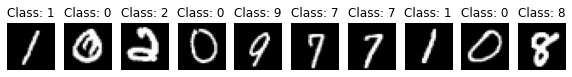

In [8]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

batch_size is the size of data used for each iteration before the model is updated.

In [9]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

To train our classifier, we need (besides the data):

A model that depend on parameters.Here we are going to use neural networks.
A loss function to measure the capabilities of the model.
An optimization method.

The linear layers in PyTorch perform a basic y = xW +b computation. These "fully connected" layers connect each input to each output with some weight parameter.

In [10]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

We now need:

a) A loss function J,
 where J is a function of the parameters W and b.

b) An optimization method or optimizer such as the stochastic gradient descent (sgd) method (Other choices could be the Adam optimizer, RMSprop, Adagrad).  For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

c) A learning rate (lr). The learning rate controls how far we move during each step or iteration.

In [11]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


Let us now train our first model. A training step is comprised of:

1) A forward pass: the input is passed through the network
2) Backpropagation: A backward pass to compute dJ/dW, i.e the gradient of the loss function with the parameters of the network.
3) Weight updates: Wc= W - (lr)* dJ/dW
 where lr is the learning rate.

Things to note:
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.

- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
  
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.

In [12]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [13]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [14]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.9080638346672059, accuracy: 83.04166666666667
Epoch 1: training loss: 0.6808923347791036, accuracy: 85.34166666666667
Epoch 2: training loss: 0.5880083835919698, accuracy: 86.41250000000001
Epoch 3: training loss: 0.5357198344071706, accuracy: 86.99166666666667
Epoch 4: training loss: 0.5014283090432485, accuracy: 87.59375
CPU times: user 31min 46s, sys: 1.61 s, total: 31min 48s
Wall time: 1min 24s


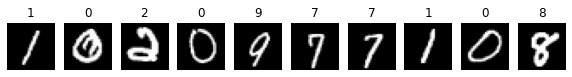

In [15]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Now, let's check the model accuracy with the validation data.

In [16]:
acc_val, loss_val = evaluate(val_dataloader, linear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.4937, validation accuracy: 87.64%


 The following function shows the cases of failure for our classifier.

In [17]:
def show_failures(model, dataloader, maxtoshow=100):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 100 first failures. The predicted class is shown first and the correct class in parentheses.


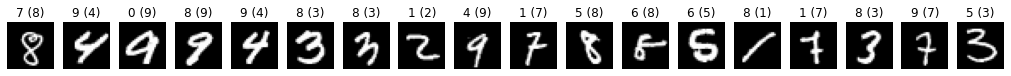

In [18]:
show_failures(linear_model, val_dataloader)

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.